<a href="https://colab.research.google.com/github/jsberriman/JSB-Thinkful-DSF/blob/master/Module_25_Supervised_Learning_Capstone_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline:

* My goal for this project is to use supervised learning approaches to explain and predict the rating scores left by consumers, using an NLP/sentiment assessment of text summaries left by the same consumers
* The dataset I've chosen is the Amazon Fine Foods Reviews data from Kaggle: https://www.kaggle.com/snap/amazon-fine-food-reviews
* The process I hope to follow is outlined as such:
  * Explore the data: Understand the nature of features and target, and do initial data cleaning, including identifing any gaps in the data and feature engineering as necessary
  * NLP Feature Extraction: leverage some simple NLP tools to extract features from the available data
  * Supervised Learning: treating the problem as a classification task, train several supervised learning models, (logistic regression, K Nearest Neighbors, Support Vector Machines, and more).
  * Model Comparison Part 1: compare performance of initial models based on accuracy/error rates and identify (3) top-performing models
  * Model Tuning: Optimize any relevant hyperparameters or features in (3) top-performing models, seeking better generalizeability, and identify top performer
* The questions I'm hoping to explore are:
  * Can we effectively train a model to classify and predict consumer rating (1 to 5 stars) using text-based reviews?
  * How does binarization of our data, creating a 2-class problem from a 5-class, influence the accuracy of our model(s)?
* Significance/Relevance: classification of reviews, prediction of class based on text only features, use of unstructured data to model interval-scale data, product improvement based on positive reviews  

## 1.) Setup: Let's load some of our initial dependencies, enable the Kaggle API, and load our data.  We can add additional imports needed as we go.

In [0]:
# initial library imports and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import zipfile
from google.colab import files

In [0]:
# upload my active Kaggle API key JSON
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"johnberriman","key":"fcee5980a0d9cfa3d1261fe40a8bb29f"}'}

In [0]:
# install Kaggle API client
!pip install -q kaggle

In [0]:
# move the API key to the expected directory; silence warnings
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# search for the Amazon Fine Food Reviews dataset
!kaggle datasets list -s Amazon

ref                                                        title                                               size  lastUpdated          downloadCount  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
snap/amazon-fine-food-reviews                              Amazon Fine Food Reviews                           242MB  2017-05-01 18:51:31          64081  
sid321axn/amazon-alexa-reviews                             Amazon Alexa Reviews                               164KB  2018-07-31 17:45:14           7226  
bittlingmayer/amazonreviews                                Amazon Reviews for Sentiment Analysis              493MB  2019-11-18 02:50:34          21561  
grikomsn/amazon-cell-phones-reviews                        Amazon Cell Phones Reviews                           9MB  2019-12-26 22:21:16           5737  
datafiniti/consumer-reviews-of-amazon-products             Consumer Reviews 

In [0]:
# load our dataset from Kaggle; can use --force if necessary
!kaggle datasets download -d snap/amazon-fine-food-reviews

 94% 227M/242M [00:01<00:00, 172MB/s]
100% 242M/242M [00:01<00:00, 143MB/s]


In [0]:
# check to make sure our zip file downloaded successfully
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


In [0]:
import zipfile
z = 'amazon-fine-food-reviews.zip'
unzip = zipfile.ZipFile(z)
unzip.extractall()

In [0]:
# re-check current directory to see if we successfully unzipped 
!ls

amazon-fine-food-reviews.zip  hashes.txt   Reviews.csv
database.sqlite		      kaggle.json  sample_data


In [0]:
# load our CSV to a dataframe and take a loot at the top 5 rows
affr_df = pd.read_csv('Reviews.csv')
affr_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2.) Exploratory Data Analysis: Let's look at the features available, do any processing/cleaning, and start exploring patterns in the data.  The dataset doesn't seem to have many immediately usable features, so we will extract features from review text.

Let's take a look at the columns, their data types, and whether there are any obvious nulls in the dataset.

In [0]:
affr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [0]:
null_count = affr_df.isnull().sum()
null_count[null_count>0]

ProfileName    16
Summary        27
dtype: int64

It looks like we have several object/text columns, as well as some int columns.  It seems that the only columns with nulls are two of the text columns, 'ProfileName' and 'Summary'. The rest are numerical/int columns.

The first few columns, Id, ProductId, UserId, and ProfileName are unlikely to be useful as features.  We can drop them moving forward.

The column 'Time', needs to be converted to DateTime to be helpful.  If we were interested in looking at multiple reviews for a product across time, or more global reviewing patterns across time, this would be useful.  Since that's out of scope for this project, we'll also drop this column.

The Summary and Text columns seem to be the most relevant for our planned NLP analysis.  Looking at the null counts, it seems there are a few nulls in 'Summary', which will be our primary feature column, we'll just drop any rows where summary is null.  Losing 27 among the 568454 responses should have little effect on our model. 

In [0]:
# Drop NA rows 
affr_df = affr_df.dropna(axis = 0, how ='any')

# Drop non-feature columns
affr_df.drop(['Id', 'ProductId', 'UserId', 'ProfileName'], axis=1, inplace=True)
affr_df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


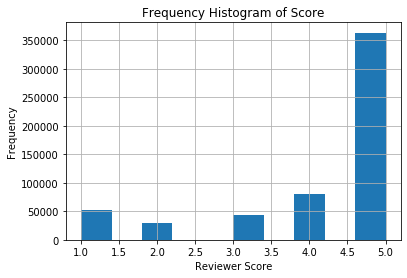

In [0]:
affr_df.Score.hist()
plt.title('Frequency Histogram of Score')
plt.xlabel('Reviewer Score')
plt.ylabel('Frequency')
plt.show()

In [0]:
affr_df.Score.describe()

count    568411.000000
mean          4.183309
std           1.310368
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

In [0]:
affr_df.Score.value_counts(normalize=True)

5    0.638818
4    0.141896
1    0.091948
3    0.075013
2    0.052327
Name: Score, dtype: float64

So our target variable, 'Score', contains interval data and ranges from 1 to 5 in whole number increments.

Clearly there is an upward skew to this, with ~64% of responses indicating a 5 star rating.  

Now, let's look at the 'Helpfulness' columns.  

In [0]:
affr_df.HelpfulnessNumerator.describe()

count    568411.000000
mean          1.743874
std           7.636781
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64

In [0]:
affr_df.HelpfulnessNumerator.value_counts(normalize=True)

0      0.534495
1      0.204850
2      0.094520
3      0.051032
4      0.029843
         ...   
126    0.000002
231    0.000002
233    0.000002
153    0.000002
491    0.000002
Name: HelpfulnessNumerator, Length: 231, dtype: float64

In [0]:
affr_df.HelpfulnessDenominator.describe()

count    568411.000000
mean          2.227876
std           8.288752
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [0]:
affr_df.HelpfulnessNumerator.value_counts(normalize=True)

0      0.534495
1      0.204850
2      0.094520
3      0.051032
4      0.029843
         ...   
126    0.000002
231    0.000002
233    0.000002
153    0.000002
491    0.000002
Name: HelpfulnessNumerator, Length: 231, dtype: float64

Text(0.5, 0, 'Helpfulness Denominator')

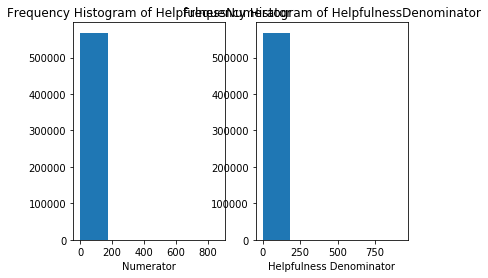

In [0]:
# Plot frequency histograms for our two 'Helpfulness' columns
fig, (ax1, ax2) = plt.subplots(1, 2) 

ax1.hist(affr_df['HelpfulnessNumerator'], bins=5)
ax1.set_title('Frequency Histogram of HelpfulnessNumerator')
ax1.set_xlabel('Numerator')
ax2.hist(affr_df['HelpfulnessDenominator'], bins=5)
ax2.set_title('Frequency Histogram of HelpfulnessDenominator')
ax2.set_xlabel('Helpfulness Denominator')

Well, those histograms are not very 'helpful' in visualizing these features.  The only thing we can visualize is that the vast majority of responses have very few scores for Helpfulness. Looking at the summary statistics and value counts on each column, we see that there is a huge range between min and max for both the numerator and denominator, and with more than half of the reviews recieving no responses for 'helpfulness' at all.  

Let's engineer a feature, called 'HelpfulnessRatio', as the ratio (numerator over denominator) of Helpful to Not Helpful responses.  We can use this to filter our dataset during modeling, to see if our model is better at predicting 'Score' for only putatively helpful reviews versus all reviews, helpful or not, in aggregate.  Since reviews with zero in both numerator and denominator will be undefined, we'll fill the zeros with 1 to avoid losing more than half of our data.

In [0]:
affr_df.loc[(affr_df.HelpfulnessNumerator == 0), 'HelpfulnessNumerator'] = 1
affr_df.loc[(affr_df.HelpfulnessDenominator == 0), 'HelpfulnessDenominator'] = 1
affr_df['HelpfulnessRatio'] = affr_df['HelpfulnessNumerator'] / affr_df['HelpfulnessDenominator']
affr_df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,1,1,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1.0
2,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,1,1,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1.0


In [0]:
affr_df.HelpfulnessRatio.value_counts(normalize=True)

1.000000    0.837257
0.500000    0.048301
0.666667    0.018495
0.333333    0.013101
0.750000    0.011196
              ...   
0.962791    0.000002
0.918367    0.000002
0.953271    0.000002
0.341463    0.000002
0.759494    0.000002
Name: HelpfulnessRatio, Length: 958, dtype: float64

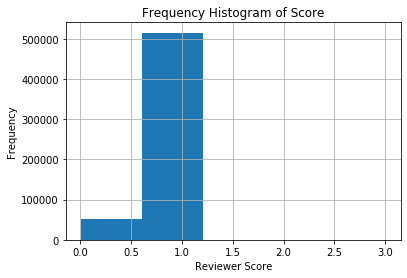

In [0]:
affr_df.HelpfulnessRatio.hist(bins=5)
plt.title('Frequency Histogram of Score')
plt.xlabel('Reviewer Score')
plt.ylabel('Frequency')
plt.show()

We retained all of our data by imputing 1 for 0, but now we definitely have an over-representation of '1's in our dataset.  We'll use the full data for this project, but a follow-up study could consider filtering for HelpfulnessRatio >1 for comparison.

The Features df now just contains the columns intended for use ('Summary', 'Text', 'ScorePolarity', and 'HelpfulnessRatio').  Now,  we need to process the 'Text' and 'Summary' columns with some NLP processing to generate useful features from the bodies of text.

Because of the number of reviews and features, we wind up hiting memory limitations down the road unless we take a subset of the data.  Let's use a subset of 100k entries to train our models.  A follow-up project with more computational resources could compare performance with the full dataset, since a broader sampling of entries would provide a lot more data and potentially improve performance (e.g. more features extracted from TFIDF).

In [0]:
affr_df_sample = affr_df.sample(n = 100000, random_state=42) # subsample 100k reviews; use these to train models
affr_df_sample.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
410090,1,2,4,1208822400,The good and the Bad,First the good.<br />If you like Starbucks cof...,0.500000
12044,12,14,5,1283299200,Best tasting sardines,"Sustainably caught off the California Coast, p...",0.857143
96685,1,1,5,1328486400,Cody B.,I loved the chips they were AWESOME!!! but tha...,1.000000
66514,4,4,5,1208563200,My little old man LOVES this food,My little 15 yo Siamese has one very small kid...,1.000000
50074,1,1,5,1327622400,GREAT...gluten free...,GREAT...gluten free...Edward & Sons Not-Beef B...,1.000000


The 100k subsample looks great.  We can also see that the index was retained, so we can see that these are unique responses and can be traced back to their position in the original dataset should we need to look back.

The remaining three columns look to be a bit more interesting.  The columns 'HelpfulnessNumerator' and 'HelpfulnessDenominator' indicate the number / proportion of other users who found the initial reviewer's feedback to be helpful.  The 'Score' column looks to be our target variable, indicating the subjective score that the reviewer gave for this product.  


I've decided to focus on predicting 'Score' using an NLP digestion of the 'Text' and/or 'Summary' initially, but the 'Helpfulness' columns could still be interesting/useful later.  Let's look at it a bit deeper at Score and Helpfulness, and once we've found what we want, we can copy to our features dataframe.

# 3.) Feature Engineering: now that we've looked at our dataset, we need to generate some useful features from the columns present.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_text = affr_df_sample['Text'].values # using .values instead of to_numpy because my pandas version won't update
vectorizer = TfidfVectorizer()
X_text_processed = vectorizer.fit_transform(X_text)

In [0]:
X_text_processed.shape

(100000, 57163)

We now have >50k features for 100k samples to train our models.  For reference, if we run TFIDF on the full datset, we get >120k features for >550k samples; the ratio of features to samples may be a better in the full dataset.  

Let's start training our models.  Let's set our target variable 'Score', run train-test-split on our data subsample, and compare performance across non-optimized models using the Confusion Matrix and their overall Accuracy.

In [0]:
# set 'Score' as our target variable
y = affr_df_sample['Score'].values # can use .to_numpy but using .values instead

In [0]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_text_processed, y, test_size=0.2, random_state=42)

Now that we have our training and test splits, we can start comparing our models.  We'll start with simpler models like logistic regression and Decision Trees, then move into more intensive models like RandomForest, KNN-C, and more. 

# 4.) Classifier Model Training and Testing

## Logistic Regression Classifier

In [0]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(solver = 'lbfgs', max_iter= 5000)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Check overall model 'accuracy'
print("Accuracy for Logistic Regression Classifier: {}".format(clf_lr.score(X_test, y_test)))

Accuracy for Logistic Regression Classifier: 0.73255


In [0]:
from sklearn import metrics
clf_lr_pred = clf_lr.predict(X_test)
print(metrics.classification_report(y_test, clf_lr_pred, target_names = ['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.66      0.63      0.65      1824
           2       0.39      0.13      0.20      1048
           3       0.47      0.28      0.35      1422
           4       0.50      0.24      0.32      2919
           5       0.78      0.96      0.86     12787

    accuracy                           0.73     20000
   macro avg       0.56      0.45      0.48     20000
weighted avg       0.69      0.73      0.69     20000



In [0]:
# Set up multiclass confusion matrix
from sklearn.metrics import confusion_matrix
clf_lr_cnf = confusion_matrix(y_test, clf_lr_pred)

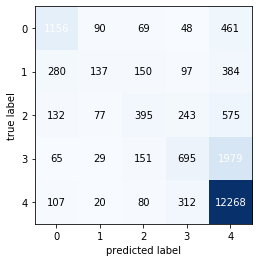

In [0]:
# visualize confusion matrix using mlxtend 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=clf_lr_cnf)

## Decision Tree classifier

In [0]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Let's look at the performance of our decision tree.  Using the testing split, we'll look at overall accuracy as well as the confusion matrix to help visualize what types of mis-classifications are occurring. We'll follow a similar template going forward for additional models. 

In [0]:
# Check overall model 'accuracy'
print("Accuracy for Decision Tree Classifier: {}".format(clf_dt.score(X_test, y_test)))

Accuracy for Decision Tree Classifier: 0.64035


In [0]:
from sklearn import metrics
clf_dt_pred = clf_dt.predict(X_test)
print(metrics.classification_report(y_test, clf_dt_pred, target_names = ['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.44      0.42      0.43      1824
           2       0.28      0.23      0.25      1048
           3       0.31      0.29      0.30      1422
           4       0.35      0.33      0.34      2919
           5       0.78      0.81      0.80     12787

    accuracy                           0.64     20000
   macro avg       0.43      0.42      0.42     20000
weighted avg       0.63      0.64      0.63     20000



In [0]:
# Set up multiclass confusion matrix
from sklearn.metrics import confusion_matrix
clf_dt_cnf = confusion_matrix(y_test, clf_dt_pred)

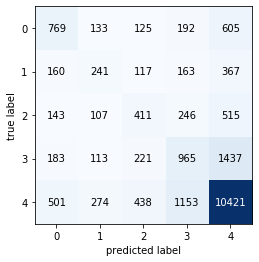

In [0]:
# visualize confusion matrix using mlxtend 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=clf_dt_cnf)

## Random Forest Classifier

Now let's train a RandomForest. Because RF is a bagged model, and takes subsets of the samples and features, we need to specify what proportions the model can use in each individual tree.  We'll specify n_samples and n_features to match what is available from our subsample of 100k reviews, specify 10k trees/estimators, and leave other hyperparameters (informative/redundant/depth/etc.) alone for now.  We can adjust these later in an optimization pass.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X_train, y_train = make_classification(n_samples=10000, n_features=57163, 
                                       n_informative=10000, n_redundant=100, 
                                       random_state=42, shuffle=False)

In [0]:
clf_rf = RandomForestClassifier(max_depth=5, n_estimators=10000, random_state=42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Check overall model 'accuracy'
print("Accuracy for RandomForest Classifier: {}".format(clf_rf.score(X_test, y_test)))

Accuracy for RandomForest Classifier: 0.0912


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf_rf_pred = clf_rf.predict(X_test)
print(metrics.classification_report(y_test, clf_rf_pred, target_names = ['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.09      1.00      0.17      1824
           2       0.00      0.00      0.00      1048
           3       0.00      0.00      0.00      1422
           4       0.00      0.00      0.00      2919
           5       0.00      0.00      0.00     12787

    accuracy                           0.09     20000
   macro avg       0.02      0.20      0.03     20000
weighted avg       0.01      0.09      0.02     20000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
clf_rf_cnf = confusion_matrix(y_test, clf_rf_pred)

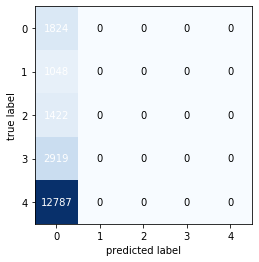

In [0]:
# visualize confusion matrix using mlxtend 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=clf_rf_cnf)

Our RandomForest appears to only be predicting one class (0).  A quick search indicates that, for datasets where individual features are pooly correlated with the target variable, such as sparse arrays generated by TFIDF, a RandomForest can get stuck and only predict one class.  We'll optimize this in the next section and hope for better performance than just the base rate.

## K-Nearest Neighbors Classifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier( )
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
# Check overall model 'accuracy'
print("Accuracy for KNN Classifier: {}".format(clf_knn.score(X_test, y_test)))

Accuracy for KNN Classifier: 0.65585


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf_knn_pred = clf_knn.predict(X_test)
print(metrics.classification_report(y_test, clf_knn_pred, target_names = ['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.60      0.17      0.26      1824
           2       0.30      0.06      0.10      1048
           3       0.34      0.09      0.14      1422
           4       0.42      0.11      0.17      2919
           5       0.68      0.96      0.80     12787

    accuracy                           0.66     20000
   macro avg       0.47      0.28      0.29     20000
weighted avg       0.59      0.66      0.57     20000



In [0]:
clf_knn_cnf = confusion_matrix(y_test, clf_knn_pred)

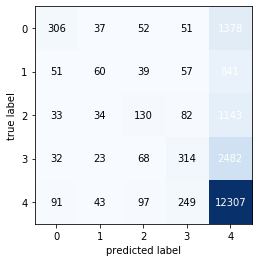

In [0]:
# visualize confusion matrix using mlxtend 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=clf_knn_cnf)

## Support Vector Machine Classifier

The last 'off the shelf' model we'll train is SVM.  We'll try the LinearSVC implementation so we can compare more easily if/when we address this model in the optimization section. 

The only change we'll make up front is to use L1 regularization instead of the default L2.  Because our data is so sparse, L1 is likely to perform better than L2 for our purposes.

In [0]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
# using the settings for make_classification that we used for RandomForest
X_train, y_train = make_classification(n_samples=10000, n_features=57163, 
                                       n_informative=10000, n_redundant=100, 
                                       random_state=42, shuffle=False)

In [0]:
clf_svm = LinearSVC(penalty='l1', dual=False, random_state=42, tol=1e-5)
clf_svm.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=42, tol=1e-05,
          verbose=0)

In [0]:
# Check overall model 'accuracy'
print("Accuracy for SVM Classifier: {}".format(clf_svm.score(X_test, y_test)))

Accuracy for SVM Classifier: 0.06105


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf_svm_pred = clf_svm.predict(X_test)
print(metrics.classification_report(y_test, clf_svm_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.10      0.67      0.17      1824
           2       0.00      0.00      0.00      1048
           3       0.00      0.00      0.00      1422
           4       0.00      0.00      0.00      2919
           5       0.00      0.00      0.00     12787

    accuracy                           0.06     20000
   macro avg       0.02      0.11      0.03     20000
weighted avg       0.01      0.06      0.02     20000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
clf_svm_cnf = confusion_matrix(y_test, clf_svm_pred)

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


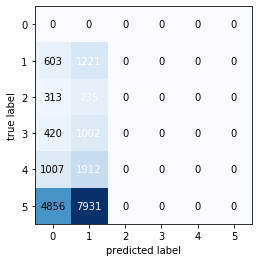

In [0]:
# visualize confusion matrix using mlxtend 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=clf_svm_cnf)

## XGBoost Classifier
As one of the top ensemble performers, it makes sense to include XGBoost in our model comparison.

In [0]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Check overall model 'accuracy'
print("Accuracy for XGBoost Classifier: {}".format(clf_xgb.score(X_test, y_test)))

Accuracy for RandomForest Classifier: 0.6686


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf_xgb_pred = clf_xgb.predict(X_test)
print(metrics.classification_report(y_test, clf_xgb_pred, target_names = ['1', '2', '3', '4', '5']))
clf_xgb_cnf = confusion_matrix(y_test, clf_xgb_pred)

              precision    recall  f1-score   support

           1       0.76      0.18      0.29      1824
           2       0.43      0.02      0.03      1048
           3       0.59      0.06      0.10      1422
           4       0.54      0.09      0.15      2919
           5       0.67      0.99      0.80     12787

    accuracy                           0.67     20000
   macro avg       0.60      0.27      0.28     20000
weighted avg       0.64      0.67      0.57     20000



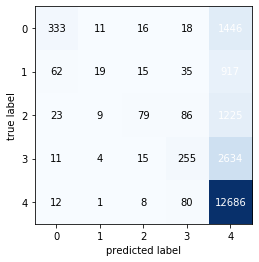

In [0]:
# visualize confusion matrix using mlxtend 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=clf_xgb_cnf)

# 5.) Initial Model Comparison


Let's compare unweighted Accuracy first to see in a gross sense how our models are performing.
* Logistic Regression: 0.73255
* Decision Tree: 0.64035
* RandomForest: 0.0912
* KNN: 0.65585
* SVM: 0.06105
* XGBoost: 0.6686

For now, the clear winner is actually the simplest algorithm: Logistic Regression (73%).  The bonus algorithm, XGBoost, comes in at a distant second with 67%.  KNN (~66%) is a the middling performer in third place, and I will optimize it and see how it fares against the top two.  A few models seem to get 'lost' in the sparse dataset, which is mostly zeroes, as is normal for TFIDF-generated features.  The reason this occurs with this application of RandomForest is because of a computational limitation.  I can't run the full number of samples or features, as it crashes even a high-RAM runtime on Colab, and never finishes when run locally on my machine.  A strong consideration for model selection is performance relative to available resources (hardware, time, etc.). Given the size of our dataset, it's not surprising that it's computationally intensive.  SVM also doesn't perform as intended; perhaps the classes are not linearly separable due to the number of shared and/or missing features in our sparse dataset.  A linear kernel won't be able to separate non-linearly separable classes, and thus it seems unable to correctly classify most of the findings, dumping everything into either 1 or 2 star classes.  Running an RBF or polynomial kernel might do the trick, but given the size of our dataset and the aforementioned computational limitations I won't try those more intensive kernels which just crash the runtime.  Due to these computational constraints, I'll drop RF and SVM from our consideration and focus on Logistic Regression, KNN, and XGBoost.  

After I optimize the top three performers, I can take a deeper look at the confusion matrices for each model.  For now, a quick skim of the models that do finish indicates that the majority of classification errors is actually in the 1 star category.  XGBoost and KNN correctly classify about 300+ of the roughly 1800 1 star ratings, whereas Logistic Regression correctly classifies 1150-ish of them.  This better classification of 1 star reviews accounts for much of the improvement in overall accuracy (~6-8%) over the other two models. I'll keep an eye on the per-class accuracy after optimization, and print a normalized confusion matrix to make the per-class accuracy a little easier to visualize, especially given the stark class imbalance.

# 6.) Optimization of Top Performers by GridSearchCV

Based on our initial model comparison, I've decided to try to optimize Logistic Regression, KNN, and XGBoost classifiers.  To achieve this, we'll employ grid search to test different values for relevant hyperparameters specific to each model, and use the cross-validated implementation to get some robustness to these estimates (GridSearchCV).

There are a lot of potential hyperparameters to test for each model.  Due to the computational limitations, I'll only pursue a few key hyperparameters for each model.


## Logistic Regression GridSearchCV

I'll do gridsearch across a few hyperparameters for this project

Since we learned l1 (lasso) and l2 (ridge) regularization earlier in the curriculum, I wanted to include those in the GridSearch. Unfortunately only L2 is supported for the lbfgs solver.

Additionally, we learned about lambda, or SKlearn's implementation as "C".  I'll explore that hyperparamter, and it's interaction with regularization on the resulting logistic regression model to hopefully mitigate any overfitting.

We can also explore iterations (max_iter) to see how the model converges across additional iterations.

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_cv_params = {"C": np.logspace(-1,1,10), "max_iter": [1000, 5000, 10000]}
clf_lr = LogisticRegression()
clf_lr_optimized = GridSearchCV(clf_lr, lr_cv_params, cv=5)

In [0]:
clf_lr_optimized.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
                         'max_iter': [1000, 5000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# Check per-grid model 'accuracy'
print("Accuracy for Logistic Regression Classifier Grids: {}".format(clf_lr_optimized.cv_results_))

Accuracy for Logistic Regression Classifier Grids: {'mean_fit_time': array([ 20.54992661,  20.44768906,  20.43586836,  25.46878963,
        25.52496228,  26.00203881,  32.57399631,  33.39406004,
        32.35060434,  39.91601825,  40.05834599,  39.41408267,
        51.42663751,  51.51146331,  52.34582887,  61.67989998,
        61.40725336,  59.98273859,  75.70241828,  75.98139467,
        77.67206345,  99.07418561,  95.92209525,  95.60502043,
       119.043608  , 116.54246101, 116.31297112, 147.01930051,
       144.34490271, 145.16077685]), 'std_fit_time': array([0.45181426, 0.46901138, 0.49319605, 0.6145044 , 0.61127067,
       0.68652981, 0.91619588, 1.02301185, 0.93549142, 0.67455508,
       0.64574495, 0.35084214, 1.5580129 , 1.57430145, 1.14133378,
       2.67822002, 1.82776305, 2.08818811, 2.63414684, 2.6902825 ,
       3.12870156, 3.23676102, 2.60022797, 2.32300336, 5.26908018,
       5.46970992, 5.29687587, 7.41316094, 6.19139386, 7.19790819]), 'mean_score_time': array([0.01649

In [0]:
# Print parameters for best-performing grid
print('Best params: %s' % clf_lr_optimized.best_params_)
# Best training data accuracy
print('Best GridSearchCV training accuracy: %.3f' % clf_lr_optimized.best_score_)

Best params: {'C': 3.593813663804626, 'max_iter': 1000}
Best GridSearchCV training accuracy: 0.733


In [0]:
# Train model on full training split w/ best params determined by GridSearchCV 
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(C=3.594813663804626, max_iter=1000)
clf_lr_optimized_final = clf_lr.fit(X_train, y_train)
# Make predictions w/ best params
y_pred = clf_lr_optimized_final.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
# Test data accuracy of model with best params
print('Test set accuracy score for Logistic Regression Classifier w/ best params: %.3f ' % accuracy_score(y_test, y_pred))

Test set accuracy score for Logistic Regression Classifier w/ best params: 0.736 


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(metrics.classification_report(y_test, y_pred, target_names = ['1', '2', '3', '4', '5']))
clf_xgb_cnf = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.67      0.66      0.66      1824
           2       0.40      0.22      0.28      1048
           3       0.44      0.31      0.36      1422
           4       0.49      0.28      0.36      2919
           5       0.80      0.94      0.87     12787

    accuracy                           0.74     20000
   macro avg       0.56      0.48      0.51     20000
weighted avg       0.70      0.74      0.71     20000



Confusion matrix, without normalization
[[ 1198   129    97    48   352]
 [  282   228   159    97   282]
 [  126   122   445   228   501]
 [   60    53   188   813  1805]
 [  114    40   132   470 12031]]
Normalized confusion matrix
[[0.66 0.07 0.05 0.03 0.19]
 [0.27 0.22 0.15 0.09 0.27]
 [0.09 0.09 0.31 0.16 0.35]
 [0.02 0.02 0.06 0.28 0.62]
 [0.01 0.   0.01 0.04 0.94]]


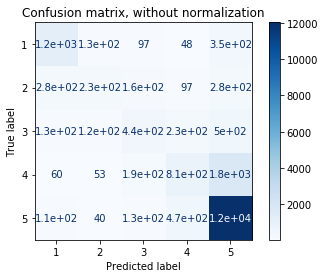

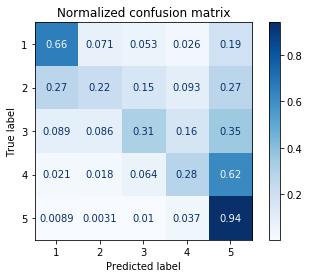

In [0]:
# plot confusion matrix without and with normalization
from sklearn.metrics import plot_confusion_matrix

class_names = ['1', '2', '3', '4', '5']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_lr_optimized_final, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## KNN-C GridSearchCV

There are several hyperparameters we could explore.  
The most significant is K, or number of neighbors used to establish the classification.
Also interesting to probe is the distance metric used to calculate distance between neighbors. SKlearn supports numerous distance measures, and since I don't understand most of them, I'll consider them out of scope for the moment.  I'll pick the two that are straightforward and approachable for me, and see how they perform. 

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_cv_params = {"n_neighbors": [3,5,10], "metric": ['euclidean', 'manhattan']}
clf_knn = KNeighborsClassifier()
clf_knn_optimized = GridSearchCV(clf_knn, knn_cv_params, cv=5, n_jobs = -1)

In [0]:
clf_knn_optimized.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# Print per-grid model performance
print("Parameters for KNN Classifier Grids: {}".format(clf_knn_optimized.cv_results_))

Parameters for KNN Classifier Grids: {'mean_fit_time': array([0.08507133, 0.05030603, 0.05905766, 0.04587517, 0.0563827 ,
       0.04696603]), 'std_fit_time': array([0.01958109, 0.00960556, 0.01367848, 0.00151529, 0.01041086,
       0.00070072]), 'mean_score_time': array([ 114.99556098,  119.27788997,  115.37443318, 1229.26458564,
       1236.10640564, 1151.67501931]), 'std_score_time': array([ 3.77772863,  2.41010019,  3.9069061 ,  2.6636643 ,  5.63242763,
       76.47504048]), 'param_metric': masked_array(data=['euclidean', 'euclidean', 'euclidean', 'manhattan',
                   'manhattan', 'manhattan'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_neighbors': masked_array(data=[3, 5, 10, 3, 5, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'metric': 'euclidean', 'n_neighbors': 3}, {'metric': 'euclidean', 'n_neighbors': 5}, {

In [0]:
# Print parameters for best-performing grid
print('Best params: %s' % clf_knn_optimized.best_params_)
# Best training data accuracy
print('Best GridSearchCV training accuracy: %.3f' % clf_knn_optimized.best_score_)

Best params: {'metric': 'manhattan', 'n_neighbors': 3}
Best GridSearchCV training accuracy: 0.654


In [0]:
# Train model on full training split w/ best params determined by GridSearchCV 
clf_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
clf_knn_optimized_final = clf_knn.fit(X_train, y_train)
# Make predictions w/ best params
y_pred = clf_knn_optimized_final.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
# Test data accuracy of model with best params
print('Test set accuracy score for KNN Classifier w/ best params: %.3f ' % accuracy_score(y_test, y_pred))

Test set accuracy score for KNN Classifier w/ best params: 0.661 


## XGBoost GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
# Optimize for accuracy since that is the metric we used earlier to score models
# Explore max_depth and min_child_weight via GridSearchCV
# Reducing subsample and colsample to 0.6 to avoid RAM overrun

xgb_cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
xgb_ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'seed':0, 'subsample': 0.6, 'colsample_bytree': 0.6, 
             'objective': 'multi:softprob', 'num_class': 5}
clf_xgb_optimized = GridSearchCV(XGBClassifier(**xgb_ind_params),
                            xgb_cv_params, 
                            scoring = 'accuracy', cv = 5, n_jobs = -1)

In [0]:
clf_xgb_optimized.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, num_class=5,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=0.6, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
             pre_dispatch='2*n_jobs', refit=True

In [0]:
# Check per-grid model results
print("Accuracy for XGBoost Classifier Grids: {}".format(clf_xgb_optimized.cv_results_))

Accuracy for XGBoost Classifier Grids: {'mean_fit_time': array([239.49633164, 234.83058887, 232.7935792 , 395.58198743,
       390.73524346, 384.11261158, 559.71830821, 544.04163804,
       479.79224582]), 'std_fit_time': array([ 1.03330956,  0.55936559,  0.48121445,  1.44720506,  1.34681724,
        2.23563708,  1.18070207,  1.18308471, 60.45929325]), 'mean_score_time': array([0.91807246, 0.88803458, 0.88736854, 1.13995485, 1.13755188,
       1.13183656, 1.56076622, 1.5801827 , 1.32419825]), 'std_score_time': array([0.02608596, 0.03716661, 0.01846848, 0.01340961, 0.02119539,
       0.00882518, 0.01660191, 0.02803824, 0.25516256]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
             mask=[False, False, False, False, False, False, False, F

In [0]:
# Print parameters for best-performing grid
print('Best params: %s' % clf_xgb_optimized.best_params_)
# Best training data accuracy
print('Best GridSearchCV training accuracy: %.3f' % clf_xgb_optimized.best_score_)

Best params: {'max_depth': 7, 'min_child_weight': 1}
Best GridSearchCV training accuracy: 0.700


In [0]:
# Train model on full training split w/ best params determined by GridSearchCV 
clf_xgb = XGBClassifier(max_depth= 7, min_child_weight = 1)
clf_xgb_optimized = clf_xgb.fit(X_train, y_train)
# Make predictions w/ best params
y_pred = clf_xgb_optimized.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
# Test data accuracy of model with best params
print('Test set accuracy score for XGBoost Classifier w/ best params: %.3f ' % accuracy_score(y_test, y_pred))

Test set accuracy score for XGBoost Classifier w/ best params: 0.702 


# 7.) Optimized Model Comparison:



GridSearchCV enabled us to modestly improve the accuracy of all three of our supervised learning algorithms by optimizing some of the hyperparameters.
* Logistic Regression: 0.73255 -> 0.736
* KNN: 0.65585 -> 0.661
* XGBoost: 0.6686 -> 0.702

While these aren't massive improvements, I didn't expect sweeping change since I only explored a couple of hyperparameters and for relatively few values due to computational limitations.  A more in-depth optimization of each hyperparameter could potentially yield more impressive gains.  Still, this illustrates the value of hyperparameter optimization, and gives us our top-performing model - Logistic Regression!

# 8.) Comparison with Binarized Reviews

Previously, we used the feature 'Score' with all 5 classes (1 to 5 stars) for our classification tasks. To compare performance, let's turn this into a binary classification task.  

Recall that earlier we found our target variable, 'Score', contains interval data and ranges from 1 to 5 in whole number increments.  Also, there was a clear upward skew to the 'Score' data, with ~64% of responses indicating a 5 star rating. Binarizing the data will hopefully improve our accuracy by addressing some of the issues stemming from the aforementioned class imbalance, both from collapsing under-represented classes as well as by utilizing binary classifiers that are more robust to class imbalance. 

Let's engineer a new feature, Score_Polarity, where we assign scores of 4 and 5 as a positive score (1) and scores of 1 or 2 as a negative score (0).  The positive or negative scores from Score_Polarity will be used with positive or negative sentiment in our models later.  Note that Score of 3, which is more neutral, is less interesting from a sentiment perspective, so we will drop these values. 

In [0]:
# re-load original DF
affr_df_2 = pd.read_csv('Reviews.csv')
affr_df_2.head()

# Drop NA rows 
affr_df_2 = affr_df_2.dropna(axis = 0, how ='any')

# Drop non-feature columns
affr_df_2.drop(['Id', 'ProductId', 'UserId', 'ProfileName'], axis=1, inplace=True)
affr_df_2.head()

# subsample 100k reviews
affr_df_2_sample = affr_df.sample(n = 100000, random_state=42) # subsample 100k reviews; use these to train models
affr_df_2_sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


In [0]:
# create new feature 'ScorePolarity'
affr_df_2_sample['ScorePolarity'] = affr_df_2_sample['Score'].apply(lambda Score: 1 if Score > 3 else 0)
affr_df_2_sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ScorePolarity
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,1
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...,1
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...,0
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...",0
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...,1


In [0]:
affr_df_2_sample.ScorePolarity.value_counts()

1    78263
0    21737
Name: ScorePolarity, dtype: int64

I now have a binary feature to do classification on.  It seems to be fairly imbalanced (78% to 21%) - expected, given the imbalanced distribution of our full five class data.  

In [0]:
# Run TFIDF on the 'Text' column to extract 1-gram features
from sklearn.feature_extraction.text import TfidfVectorizer

X_text = affr_df_2_sample['Text'].values # using .values instead of to_numpy because my pandas version won't update
vectorizer = TfidfVectorizer()
X_text_processed = vectorizer.fit_transform(X_text)

In [0]:
# set 'ScorePolarity' as our new target variable
y = affr_df_2_sample['ScorePolarity'].values

In [0]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_text_processed, y, test_size=0.2, random_state=42)

Let's run GridSearchCV, as before, but on the binarized data.  Let's pit our two top performers against each other again, and compare outcomes.

## Logistic Regression GridSearchCV - Binary Data

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_cv_params = {"C": np.logspace(-1,1,3,10), "max_iter": [1000, 3000, 5000]}
clf_lr = LogisticRegression()
clf_lr_optimized = GridSearchCV(clf_lr, lr_cv_params, cv=5)

In [0]:
clf_lr_optimized.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.1,  1. , 10. ]),
                         'max_iter': [1000, 3000, 5000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# Check per-grid model 'accuracy'
print("Accuracy for Logistic Regression Classifier Grids: {}".format(clf_lr_optimized.cv_results_))

Accuracy for Logistic Regression Classifier Grids: {'mean_fit_time': array([ 2.38571658,  2.40639124,  2.43884525,  6.21155086,  6.19981084,
        6.15318441, 14.33851509, 14.27001939, 14.55306249]), 'std_fit_time': array([0.11850293, 0.10763562, 0.1338853 , 0.39131626, 0.39770302,
       0.34294811, 0.51634412, 0.51686584, 0.50309691]), 'mean_score_time': array([0.00629663, 0.00624018, 0.00627956, 0.00614305, 0.0062799 ,
       0.00603008, 0.00603671, 0.00596552, 0.00640569]), 'std_score_time': array([4.54966473e-04, 1.66882542e-04, 3.42231234e-04, 1.82795349e-04,
       2.40272344e-04, 9.45630723e-05, 2.01643119e-04, 1.69154674e-04,
       2.61638798e-04]), 'param_C': masked_array(data=[0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_max_iter': masked_array(data=[1000, 3000, 5000, 1000, 3000, 5000, 1000, 3000, 5000],
       

In [0]:
# Print parameters for best-performing grid
print('Best params: %s' % clf_lr_optimized.best_params_)
# Best training data accuracy
print('Best GridSearchCV training accuracy: %.3f' % clf_lr_optimized.best_score_)

Best params: {'C': 10.0, 'max_iter': 1000}
Best GridSearchCV training accuracy: 0.893


In [0]:
# Train model on full training split w/ best params determined by GridSearchCV 
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(C=10, max_iter=1000)
clf_lr_optimized_final = clf_lr.fit(X_train, y_train)
# Make predictions w/ best params
y_pred = clf_lr_optimized_final.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
# Test data accuracy of model with best params
print('Test set accuracy score for Logistic Regression Classifier w/ best params: %.3f ' % accuracy_score(y_test, y_pred))

Test set accuracy score for Logistic Regression Classifier w/ best params: 0.897 


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(metrics.classification_report(y_test, y_pred, target_names = ['0', '1']))
clf_xgb_cnf = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.70      0.74      4294
           1       0.92      0.95      0.94     15706

    accuracy                           0.90     20000
   macro avg       0.86      0.82      0.84     20000
weighted avg       0.89      0.90      0.89     20000



Confusion matrix, without normalization
[[ 2989  1305]
 [  756 14950]]
Normalized confusion matrix
[[0.69608756 0.30391244]
 [0.04813447 0.95186553]]


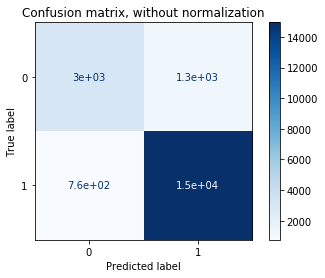

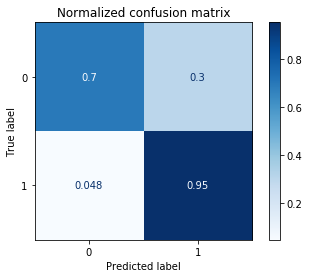

In [0]:
# plot confusion matrix without and with normalization
from sklearn.metrics import plot_confusion_matrix

class_names = ['0', '1']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_lr_optimized_final, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Logistic Regression does a pretty good job on the binary dataset.  With 89.7% accuracy, this is a pretty big overall improvement.  

Based on the confusion matrix, it looks like our classifier is doing a better job of classifying positive reviews ('1').  This makes sense, given that this is the dominant class.  Additionally, our minority class actually consists of three separate review bins (1/2/3 stars).  This diverse class may have verbiage that is harder to assign.  Also, there is likely a fair bit of overlap between verbiage used in the 3-star bin and the 4- and 5-star bins, given that 3 stars is somewhat neutral.  

## XGBoost GridSearchCV - Binary Data

In [0]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb_cv_params = {'max_depth': [1,3,5], 'min_child_weight': [1,3], 
                 'learning_rate': [0.01, 0.1]}
                 
xgb_ind_params = {'n_estimators': 100, 'seed':0, 'subsample': 0.6, 
                  'colsample_bytree': 0.6, 'objective': 'binary:logistic'}

clf_xgb_optimized = GridSearchCV(XGBClassifier(**xgb_ind_params),
                            xgb_cv_params, 
                            scoring = 'accuracy', cv = 5, n_jobs = -1)

In [0]:
clf_xgb_optimized.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=0.6, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [1, 3, 5],
                         'min_child_weight': [1, 3]},
             pre_dispatch='2*n_jobs', refit=T

In [0]:
# Check per-grid model results
print("Accuracy for XGBoost Classifier Grids: {}".format(clf_xgb_optimized.cv_results_))

Accuracy for XGBoost Classifier Grids: {'mean_fit_time': array([22.41421118, 21.48103647, 52.06672711, 50.93543296, 83.01315703,
       81.48893318, 21.50692725, 21.16645708, 51.55001869, 50.71207733,
       82.71785655, 73.54850979]), 'std_fit_time': array([0.46157971, 0.07045396, 0.16176721, 0.08004715, 0.36711232,
       0.3136601 , 0.13652916, 0.10138283, 0.11972806, 0.20918083,
       0.26183863, 8.66337801]), 'mean_score_time': array([0.63294291, 0.62127924, 0.63647599, 0.67723927, 0.70249238,
       0.70784535, 0.66754808, 0.65928288, 0.66774735, 0.66031647,
       0.69835486, 0.59521523]), 'std_score_time': array([0.03597214, 0.00811984, 0.01542404, 0.03633786, 0.04938391,
       0.05191236, 0.06379423, 0.07075544, 0.0548908 , 0.03496684,
       0.04950505, 0.20249793]), 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1,
                   0.1, 0.1],
             mask=[False, False, False, False, False, False, False, False,
       

In [0]:
# Print parameters for best-performing grid
print('Best params: %s' % clf_xgb_optimized.best_params_)
# Best training data accuracy
print('Best GridSearchCV training accuracy: %.3f' % clf_xgb_optimized.best_score_)

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1}
Best GridSearchCV training accuracy: 0.847


In [0]:
# Train model on full training split w/ best params determined by GridSearchCV 
clf_xgb = XGBClassifier(learning_rate= 0.1, max_depth= 5, min_child_weight = 1)
clf_xgb_optimized = clf_xgb.fit(X_train, y_train)
# Make predictions w/ best params
y_pred = clf_xgb_optimized.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
# Test data accuracy of model with best params
print('Test set accuracy score for XGBoost Classifier w/ best params: %.3f ' % accuracy_score(y_test, y_pred))

Test set accuracy score for XGBoost Classifier w/ best params: 0.844 


In [0]:
# Set up classification report and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(metrics.classification_report(y_test, y_pred, target_names = ['0', '1']))
clf_xgb_cnf = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.84      0.36      0.50      4422
           1       0.84      0.98      0.91     15578

    accuracy                           0.84     20000
   macro avg       0.84      0.67      0.71     20000
weighted avg       0.84      0.84      0.82     20000



Confusion matrix, without normalization
[[ 1591  2831]
 [  299 15279]]
Normalized confusion matrix
[[0.35979195 0.64020805]
 [0.01919373 0.98080627]]


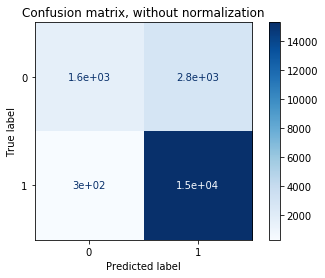

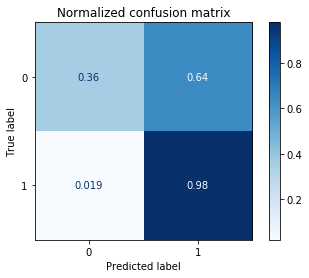

In [0]:
# plot confusion matrix without and with normalization
from sklearn.metrics import plot_confusion_matrix

class_names = ['0', '1']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_xgb_optimized, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

XGBoost does a pretty good job on the binary dataset.  With 84.4% accuracy, this is also a pretty big overall improvement versus the 5-class dataset.  

Based on the confusion matrix, it looks like XGBoost actually does a better job of classifying positive reviews ('1') than Logistic Regression.  It seems XGBoost may be more succeptible to imbalanced classification, and is over-assigning to the dominant class.  64% of negative reviews are incorrectly predicted as positive reviews.

## Optimized Model Comparison - Binary Data

By employing GridSearchCV once again, I trained models with decent accuracy.  Compared to each model's performance in the multiclass case, the performance in the binary case was much better. 

Logistic Regression: 
 * Multiclass Accuracy: 73.6%
 * Binary Accuracy: 89.7% 

XGBoost:
 * Multiclass Accuracy: 70.2%
 * Binary Accuracy: 84.4%

However, both models were succeptible to class imbalance, and had fairly high error rates assigning due to the negative class to the positive class.

Overall, Logistic Regression is the clear winner. With better classification accuracy in both the multiclass and binary cases, and computing substantially faster, it's the clear choice.  

Follow-up study could try to optimize Logistic Regression further.  In particular, dropping the potentially confusing 3-star class and binarizing 'negative' reviews as 1- and 2-stars and positive reviews as 4- and 5-stars.  Kernels posted to Kaggle performed a similar approach to binary classification and had substantially better performance.  